In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import mat73
import pandas as pd
import os
import glob
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import scipy as sp

In [84]:
version=1
datafolder='/stelmo/shijie/behavior_pilot/Batch1'
figurefolder='/stelmo/shijie/behavior_pilot/Batch1/Plots'

#version=2
datafolder='/opt/stelmo/shijie/behavior_pilot/Batch2'
figurefolder='/opt/stelmo/shijie/behavior_pilot/Batch2/Plots'

#animals=['Baron','Baden','Astro','Acnes','Daigo','Dylon','Dabby']

animal='Molly'

datafolder='/cumulus/shijie/behavior_pilot/Batch1'
figurefolder='/cumulus/shijie/behavior_pilot/Batch1/Plots'

animal='Eliot'
#animal='Haydn'
#animal='Julio'
#animal='Klein'
#animal='Lewis'

datafolder='/stelmo/shijie/behavior_pilot/Batch3'
figurefolder='/stelmo/shijie/behavior_pilot/Batch3/Plots'
#animal = 'Marli'
#animal = 'Micah'
animal = 'Mason'

#datafolder='/opt/stelmo/shijie/recording_pilot/'
#animal='Athor'

seq1=[2,4,1,3];
seq2=[3,4,2,1];
seq3=[1,2,3,4];

rev1=[2,3,1,4];
rev2=[2,4,3,1];
rev3=[1,4,3,2];

seqs=np.vstack((seq1,seq2,seq3,rev1,rev2,rev3))

colorlist=np.array([[0, 0.4470, 0.7410],
    [0.8500, 0.3250, 0.09800],
    [0.9290, 0.6940, 0.1250],
    [0.4940, 0.1840, 0.5560],
    [0.4660, 0.6740, 0.1880],
    [0.3010, 0.7450, 0.9330]])

data=pickle.load(open(os.path.join(datafolder,animal,'behavior_'+animal+'.p'), "rb"))
reorder_ind = np.argsort(data['date_session'])

### 1. over sessions, plot occurrance of unbroken sequences

##### (a) find 1st order (1,1 or 2,2 etc) repeats-- type1: 11xx or type2: xx11 or type3: x11x
##### (b) find 2nd order (1,0,1 or 2,0,2 etc) repeats-- type1: 1x1x or type2: x1x1
##### (c) find 3nd order (1,0,0,1 or 2,0,0,2 etc) repeats-- 1xx1

In [85]:
len(data['trials'])

108

In [86]:
#path to save figures to
datafolder=os.path.split(os.path.split(data['files'][0])[0])[0]

if version==1:
    orders=['seq1','seq2','seq3','rev1','rev2','rev3','1st repeat','2nd repeat','3rd repeat']
else:
    orders=['tra1','tra2','tra3','rev1','rev2','rev3','1st repeat','2nd repeat','3rd repeat']
#order_all=np.zeros((len(data['trials']),120,9))+np.nan
order_all=np.zeros((len(data['trials']),145,9))+np.nan

session_ind = 0
for s in reorder_ind:#range(len(data['trials'])):
    trials=data['trials'][s]
    rewarded=trials[:,4]==2 #outer rewarded or not
    session_end=np.argwhere(rewarded).ravel()[-1]
    trials=trials[np.arange(session_end)]

    outers=trials[:140,3]
    
    # seq 1-3, rev 1-3
    runningsum_outer=signal.convolve(outers**2,[1,1,1,1,1])

    for se in range(6):
        conv=np.zeros(len(outers))
        for p in range(4): #permutation
            seq_tmp=np.roll(np.hstack((seqs[se],seqs[se])),-p)[:5]
            seq_norm=np.linalg.norm(seq_tmp)
            conv_tmp=signal.convolve(outers,np.flip(seq_tmp))/(seq_norm*np.sqrt(runningsum_outer))
            conv += np.concatenate(([0,0,0,0],np.abs(conv_tmp[4:-4]-1)<=np.exp(-10)));
        conv=np.array(conv>0).astype('int')
        
        order_all[session_ind,np.arange(len(outers)),se]=conv
    
    # order 1-3
    order1_2=np.concatenate([[1],np.diff(outers)])==0
    order1_1=np.concatenate([[0,0],order1_2[:-2]])
    order1_3=np.concatenate([[0],order1_2[:-1]])
    order1=((order1_1.astype('int')+order1_2.astype('int')+order1_3.astype('int'))>0).astype('int')

    order2_1=np.concatenate([[1,1],outers[2:]-outers[:-2]])==0
    order2_2=np.concatenate([[0],order2_1[:-1]])
    order2=((order2_1.astype('int')+order2_2.astype('int'))>0).astype('int')

    order3=np.concatenate([[1,1,1],outers[3:]-outers[:-3]])==0

    order_all[session_ind,np.arange(len(outers)),0+6]=order1
    order_all[session_ind,np.arange(len(outers)),1+6]=order2
    order_all[session_ind,np.arange(len(outers)),2+6]=order3
    session_ind = session_ind + 1

sum_of_projection=np.sum(order_all,axis=2)
explained=sum((sum_of_projection==1).flatten())/sum((sum_of_projection==0).flatten()+(sum_of_projection==1).flatten())
print(explained)
    

0.7827111058768107


In [87]:
'''
# Use triplet and quadrants to find sequence occurance

#order_all=np.zeros((len(data['trials']),120,9))+np.nan
order_all2=np.zeros((len(data['trials']),85,9))+np.nan
order_all3=np.zeros((len(data['trials']),85,9))+np.nan

for s in reorder_ind:#range(len(data['trials'])):
    trials=data['trials'][s]
    rewarded=trials[:,4]==2 #outer rewarded or not
    session_end=np.argwhere(rewarded).ravel()[-1]
    trials=trials[np.arange(session_end)]

    outers=trials[:120,3]
    
    # seq 1-3, rev 1-3
    runningsum_outer=signal.convolve(outers**2,[1,1,1])

    for se in range(6):
        conv=np.zeros(len(outers))
        for p in range(4): #permutation
            seq_tmp=np.roll(np.hstack((seqs[se],seqs[se])),-p)[:3]
            seq_norm=np.linalg.norm(seq_tmp)
            conv_tmp=signal.convolve(outers,np.flip(seq_tmp))/(seq_norm*np.sqrt(runningsum_outer))
            conv += np.concatenate(([0,0],np.abs(conv_tmp[2:-2]-1)<=np.exp(-10)));
        conv=np.array(conv>0).astype('int')
        
        order_all2[s,np.arange(len(outers)),se]=conv
    
    # seq 1-3, rev 1-3
    runningsum_outer=signal.convolve(outers**2,[1,1,1,1])
    for se in range(6):
        conv=np.zeros(len(outers))
        for p in range(4): #permutation
            seq_tmp=np.roll(np.hstack((seqs[se],seqs[se])),-p)[:3]
            seq_norm=np.linalg.norm(seq_tmp)
            conv_tmp=signal.convolve(outers,np.flip(seq_tmp))/(seq_norm*np.sqrt(runningsum_outer))
            conv += np.concatenate(([0,0,0],np.abs(conv_tmp[3:-3]-1)<=np.exp(-10)));
        conv=np.array(conv>0).astype('int')
        
        order_all3[s,np.arange(len(outers)),se]=conv
    
    

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-87-e89f1a3408ae>, line 43)

In [ ]:
'''
# generate random
random_rates=[]
for b in range(1000):
    order_random_all=np.zeros((len(data['trials']),120,9))+np.nan
    for s in range(len(data['trials'])):
        example_session=order_all[s,:,0]
        for t in range(len(example_session)):
            topermute=order_all[s,t,:]
            random_ind=np.random.permutation(len(topermute))
            order_random_all[s,t,np.arange(len(topermute))]=topermute[random_ind]
    
    for a in range(9):
        occurance_rate_random=np.sum(order_random_all[:,:,a]==1,axis=1)
        occurance_rates_random.append(occurance_rate_random)
    
    random_rate = np.array(occurance_rates_random)/np.sum(occurance_rates_random,axis=0)
    random_rates.append(random_rate[0])
'''

In [ ]:
order_all[:,:80,8].shape

In [ ]:
seqtype=np.array([se[3] for se in data['seq']]);
seqtype=seqtype[reorder_ind]
seqtype_int=[int(se) for se in seqtype]
sequence_change=np.argwhere(np.diff(seqtype_int)).ravel()+1

fig,axes=plt.subplots(1,9,figsize=(20, 10))
for a in range(len(axes)):
    axes[a].imshow(order_all[:,:80,a],vmin=0,vmax=1,aspect=10,interpolation='none')
    
    axes[a].set_title(orders[a],fontsize=20)
    axes[a].set_position([0.05+a*0.12,0.06,0.1,0.8])
    axes[a].set_yticks(np.arange(len(data['trials'])));
    ylim=axes[a].get_ylim()
    for t in sequence_change:
        axes[a].plot([0,85],[t-0.5,t-0.5],'w:',linewidth=2,)
        
    axes[a].set_yticklabels(seqtype,fontsize=6);
fig.suptitle(data['date_session'][0][:5],fontsize=20,x=0.5,y=0.92);
fig.text(0.02, 0.5, 'sessions', va='center',rotation='vertical',fontsize=20);
fig.text(0.5, 0.01, 'trials', ha='center',fontsize=20);

plt.savefig(os.path.join(figurefolder,'C_occurance_of_sequence_'+animal+'.png'),bbox_inches='tight',dpi=500)

In [88]:
len(data['date'])

108

In [89]:
data['date']

['20241007',
 '20241007',
 '20241008',
 '20241008',
 '20241008',
 '20241008',
 '20241009',
 '20241009',
 '20241009',
 '20241009',
 '20241010',
 '20241010',
 '20241010',
 '20241010',
 '20241011',
 '20241011',
 '20241011',
 '20241011',
 '20241012',
 '20241012',
 '20241012',
 '20241012',
 '20241014',
 '20241014',
 '20241014',
 '20241014',
 '20241015',
 '20241015',
 '20241015',
 '20241015',
 '20241016',
 '20241016',
 '20241016',
 '20241016',
 '20241017',
 '20241017',
 '20241017',
 '20241017',
 '20241018',
 '20241018',
 '20241018',
 '20241018',
 '20241019',
 '20241019',
 '20241019',
 '20241019',
 '20241020',
 '20241020',
 '20241020',
 '20241020',
 '20241021',
 '20241021',
 '20241021',
 '20241021',
 '20241022',
 '20241022',
 '20241022',
 '20241022',
 '20241024',
 '20241024',
 '20241024',
 '20241024',
 '20241025',
 '20241025',
 '20241025',
 '20241025',
 '20241026',
 '20241026',
 '20241026',
 '20241026',
 '20241027',
 '20241027',
 '20241028',
 '20241028',
 '20241029',
 '20241029',
 '20241030',

In [90]:
len(occurance_rates[0])

115

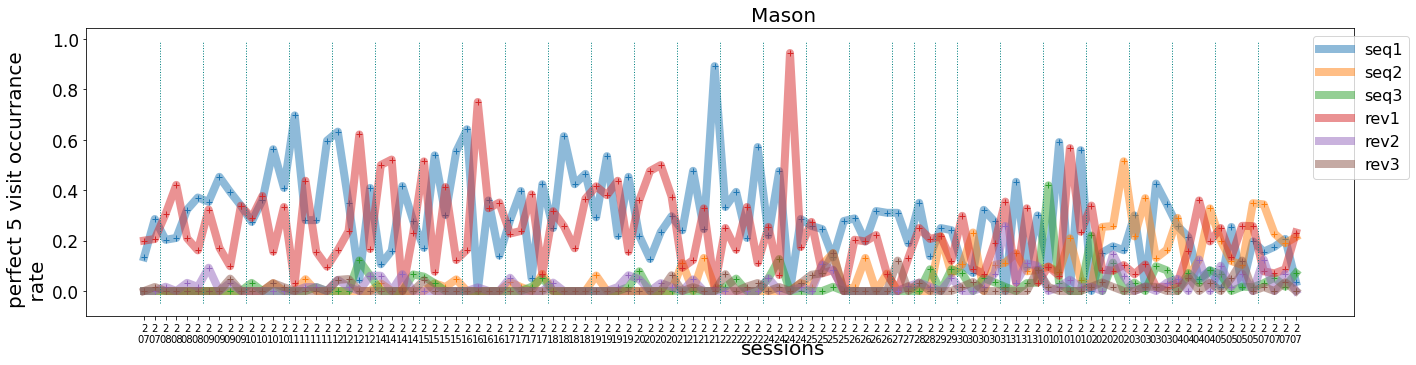

In [91]:
seqtype=np.array([se[3] for se in data['seq']]);
seqtype=seqtype[reorder_ind]
seqtype_int=[int(se) for se in seqtype]

dates=np.array([int(d) for d in data['date']])
dates=dates[reorder_ind]
occurance_rates=[]
#occurance_rates_random=[]
lines=[]

for a in range(9):
    occurance_rate=np.sum(order_all[:,:,a]==1,axis=1)
    occurance_rates.append(occurance_rate)
    
    #occurance_rate_random=np.sum(order_random_all[:,:,a]==1,axis=1)
    #occurance_rates_random.append(occurance_rate_random)
  
occurance_rates=occurance_rates/np.sum(occurance_rates,axis=0)

fig,axes=plt.subplots(1,1,figsize=(22, 5))
for a in range(6):
    occurance_rate=occurance_rates[a]
    lines1,=axes.plot(occurance_rate,color='C'+str(a),label=orders[a],linewidth=8,alpha=0.5)
    lines.append(lines1)
    axes.plot(occurance_rate,'+',color='C'+str(a))

# standard deviation
'''
random_mean=np.mean(occurance_rates,axis=0)
random_std=np.std(occurance_rates, ddof=1,axis=0)
lines1,=axes.plot(random_mean,color='C9',label='random')
axes.fill_between(np.arange(len(random_mean)), random_mean+random_std, np.maximum(random_mean-random_std,0), facecolor='C9', alpha=0.3)
lines.append(lines1)
'''

axes.legend(handles=lines,fontsize=16,bbox_to_anchor=(1.05, 1))
axes.set_position([0.06,0.11,0.8,0.8])

# seq ticks
sequence_change=np.argwhere(np.diff(seqtype_int)).ravel()+1
y3=axes.get_ylim()
for t in sequence_change:
    axes.plot([t-0.5,t-0.5],y3,'k:',linewidth=1,)

    
# day ticks
day_change=np.argwhere(np.diff(dates)).ravel()+1
y3=axes.get_ylim()
for t in day_change:
    axes.plot([t-0.5,t-0.5],y3,':',linewidth=1,color='teal')

dates=data['date'];
assert len(dates)==len(seqtype)
seqtype_d=[seqtype[d]+'\n'+dates[d][-2:] for d in range(len(dates))]

axes.set_xticks(np.arange(len(seqtype)));
axes.set_xticklabels(seqtype_d,fontsize=10);
plt.yticks(fontsize=17);

fig.suptitle(data['date_session'][0][:5],fontsize=20,x=0.5,y=0.97);
fig.text(0.01, 0.5, 'perfect 5 visit occurrance \n rate', va='center',rotation='vertical',fontsize=20);
fig.text(0.5, 0.005, 'sessions', ha='center',fontsize=20);
    
plt.savefig(os.path.join(figurefolder,'C2_rate_of_sequence_'+animal+'.png'),dpi=500)

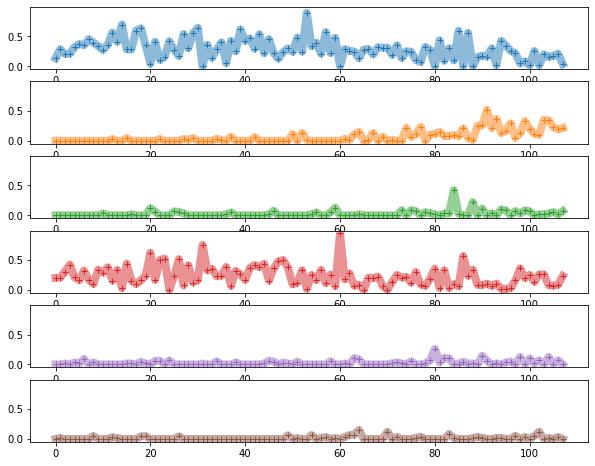

In [92]:
fig,axes=plt.subplots(6,1,figsize=(10, 8),sharey=True)
for a in range(6):
    occurance_rate=occurance_rates[a]
    lines1,=axes[a].plot(occurance_rate,color='C'+str(a),label=orders[a],linewidth=8,alpha=0.5)
    lines.append(lines1)
    axes[a].plot(occurance_rate,'+',color='C'+str(a))

In [93]:
data['date']

['20241007',
 '20241007',
 '20241008',
 '20241008',
 '20241008',
 '20241008',
 '20241009',
 '20241009',
 '20241009',
 '20241009',
 '20241010',
 '20241010',
 '20241010',
 '20241010',
 '20241011',
 '20241011',
 '20241011',
 '20241011',
 '20241012',
 '20241012',
 '20241012',
 '20241012',
 '20241014',
 '20241014',
 '20241014',
 '20241014',
 '20241015',
 '20241015',
 '20241015',
 '20241015',
 '20241016',
 '20241016',
 '20241016',
 '20241016',
 '20241017',
 '20241017',
 '20241017',
 '20241017',
 '20241018',
 '20241018',
 '20241018',
 '20241018',
 '20241019',
 '20241019',
 '20241019',
 '20241019',
 '20241020',
 '20241020',
 '20241020',
 '20241020',
 '20241021',
 '20241021',
 '20241021',
 '20241021',
 '20241022',
 '20241022',
 '20241022',
 '20241022',
 '20241024',
 '20241024',
 '20241024',
 '20241024',
 '20241025',
 '20241025',
 '20241025',
 '20241025',
 '20241026',
 '20241026',
 '20241026',
 '20241026',
 '20241027',
 '20241027',
 '20241028',
 '20241028',
 '20241029',
 '20241029',
 '20241030',

In [95]:
seqtype=np.array([se[3] for se in data['seq']]);
seqtype=seqtype[reorder_ind]
seqtype_int=[int(se) for se in seqtype]

dates=np.array([int(d) for d in data['date']])
dates=dates[reorder_ind]
occurance_rates=[]
#occurance_rates_random=[]
lines=[]

for a in range(9):
    occurance_rate=np.sum(order_all2[:,:,a]==1,axis=1)
    occurance_rates.append(occurance_rate)
    
  
occurance_rates=occurance_rates/np.sum(occurance_rates,axis=0)

fig,axes=plt.subplots(1,1,figsize=(22, 5))
for a in range(6):
    occurance_rate=occurance_rates[a]
    lines1,=axes.plot(occurance_rate,color='C'+str(a),label=orders[a],linewidth=8,alpha=0.5)
    lines.append(lines1)
    axes.plot(occurance_rate,'+',color='C'+str(a))

# standard deviation
'''
random_mean=np.mean(occurance_rates,axis=0)
random_std=np.std(occurance_rates, ddof=1,axis=0)
lines1,=axes.plot(random_mean,color='C9',label='random')
axes.fill_between(np.arange(len(random_mean)), random_mean+random_std, np.maximum(random_mean-random_std,0), facecolor='C9', alpha=0.3)
lines.append(lines1)
'''

axes.legend(handles=lines,fontsize=16,bbox_to_anchor=(1.05, 1))
axes.set_position([0.06,0.11,0.8,0.8])

# seq ticks
sequence_change=np.argwhere(np.diff(seqtype_int)).ravel()+1
y3=axes.get_ylim()
for t in sequence_change:
    axes.plot([t-0.5,t-0.5],y3,'k:',linewidth=1,)

    
# day ticks
day_change=np.argwhere(np.diff(dates)).ravel()+1
y3=axes.get_ylim()
for t in day_change:
    axes.plot([t-0.5,t-0.5],y3,':',linewidth=1,color='teal')

dates=data['date'];
assert len(dates)==len(seqtype)
seqtype_d=[seqtype[d]+'\n'+dates[d][-2:] for d in range(len(dates))]

axes.set_xticks(np.arange(len(seqtype)));
axes.set_xticklabels(seqtype_d,fontsize=10);
plt.yticks(fontsize=17);

fig.suptitle(data['date_session'][0][:5],fontsize=20,x=0.5,y=0.97);
fig.text(0.01, 0.5, 'triplet occurrance \n rate', va='center',rotation='vertical',fontsize=20);
fig.text(0.5, 0.005, 'sessions', ha='center',fontsize=20);
    
plt.savefig(os.path.join(figurefolder,'C2_rate_of_sequence_'+animal+'.png'),dpi=500)

NameError: name 'order_all2' is not defined

In [ ]:
corrcoef=np.zeros((6,6))
corrcoef_p=np.zeros((6,6))
for i in range(6):
    for j in range(6):
        corrcoef[i,j],corrcoef_p[i,j]=sp.stats.pearsonr(occurance_rates[i],occurance_rates[j])
        #corrcoef[i,j],corrcoef_p[i,j]=sp.stats.pearsonr(occurance_rates[i,:15],occurance_rates[j,:15])
        #if corrcoef_p[i,j]>0.1:
        #    corrcoef[i,j]=np.nan
    corrcoef[i,i]=np.nan

In [ ]:
plt.imshow(corrcoef)
plt.colorbar()

### 2. Pairwise Arm Transitions

In [96]:
offind=np.where(~np.eye(P_behavior_all[d].shape[0],dtype=bool))
P_behavior_all[d][offind]

array([0.125     , 0.5375    , 0.3375    , 0.44736842, 0.30263158,
       0.25      , 0.25333333, 0.26666667, 0.48      , 0.32926829,
       0.58536585, 0.08536585])

In [97]:
def find_behavior_transitions(index,outers): #P(xi|xj)
    T=np.zeros((4,4))
    for t in range(len(outers)-1):
        if (index[t+1]-index[t])==1:
            T[int(outers[t])-1,int(outers[t+1])-1] += 1 # minus 1 due to python indexing
    #for ti in range(4):
    #    T[ti]=T[ti]/np.sum(T[ti])
    return T

def matrix_correlation(M1,M2):
    '''only do for off diagnoal entries'''
    offind=np.where(~np.eye(M1.shape[0],dtype=bool))
    M1_=M1[offind]
    M2_=M2[offind]
    #M1_=M1-np.mean(M1.ravel())
    #M2_=M2-np.mean(M2.ravel())
    
    return np.corrcoef(M1_,M2_)[0,1]
    #return np.sum(np.multiply(M1_,M2_))/(np.linalg.norm(M1_,ord='fro')*np.linalg.norm(M2_,ord='fro'))

def normalize_offdiag(T_):
    T=T_.copy()
    np.fill_diagonal(T, 0)
    for ti in range(4):
        if np.sum(T[ti])!=0:
            T[ti]=T[ti]/np.sum(T[ti])
    return T

def normalize(T_):
    T=T_.copy()
    for ti in range(4):
        if np.sum(T[ti])!=0:
            T[ti]=T[ti]/np.sum(T[ti])
    return T

def remove_diag(T_):
    T=T_.copy()
    np.fill_diagonal(T, 0)
    return T

In [98]:
seq1=[2,4,1,3];
seq2=[3,4,2,1];
seq3=[1,2,3,4];

rev1=[2,3,1,4];
rev2=[2,4,3,1];
rev3=[1,4,3,2];

seqs=np.vstack((seq1,seq2,seq3,rev1,rev2,rev3))
orders=['Seq1','Seq2','Seq3','Rev1','Rev2','Rev3']

P_task=np.zeros((4,4,6))
for s in range(6):
    for a in range(4):
        P_task[seqs[s,a%4]-1,seqs[s,(a+1)%4]-1,s]=1

In [99]:
P_behavior_count=np.zeros((4,4))
P_behavior_all={}
xcorr={}

dates=np.unique(data['date'])
for d in dates:
    P_behavior_all[d]=[]

d=0
for s in range(len(data['trials'])):
    trials=data['trials'][s]
    rewarded=trials[:,4]==2 #outer rewarded or not
    session_end=np.argwhere(rewarded).ravel()[-1]
    trials=trials[np.arange(session_end)]

    outers=trials[:80,3]
    index=np.arange(len(outers))+1
    P_behavior_count=find_behavior_transitions(index,outers)
    
    if data['date'][s]!=d:
        P_behavior_all[data['date'][s]]=P_behavior_count
        d=data['date'][s]
    else:
        P_behavior_all[data['date'][s]]+=P_behavior_count
        

for d in dates:
    P_behavior_all[d]=normalize_offdiag(P_behavior_all[d])
    #P_behavior_all[d]=np.mean(np.dstack(P_behavior_all[d]),axis=2)
    xcorr_behavior_task=[matrix_correlation(P_behavior_all[d],P_task[:,:,s]) for s in range(P_task.shape[2])]
    xcorr[d]=xcorr_behavior_task
    


In [100]:
P_behavior_all[d]

array([[0.        , 0.20238095, 0.5       , 0.29761905],
       [0.46753247, 0.        , 0.19480519, 0.33766234],
       [0.27142857, 0.31428571, 0.        , 0.41428571],
       [0.36708861, 0.50632911, 0.12658228, 0.        ]])

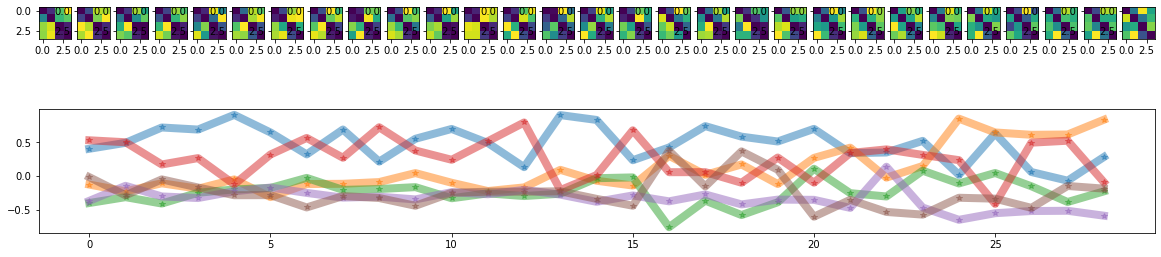

In [101]:
fig,axes=plt.subplots(2,len(dates),figsize=(20, 5))
i=0
for d in dates:
    axes[0,i].imshow(P_behavior_all[d])
    i=i+1
    
plt.subplot(2, 1, 2)
for s in range(P_task.shape[2]):
    plt.plot([xcorr[d][s] for d in dates],'*-',linewidth=8,alpha=0.5)

plt.savefig(os.path.join(figurefolder,'C3_rate_of_pairwise_'+animal+'.png'),dpi=500)

In [ ]:
fig,axes=plt.subplots(1,3,figsize=(22, 5))
axes[0].imshow(P_task[:,:,0])
axes[1].imshow(P_task[:,:,1])
axes[2].imshow(P_task[:,:,4])

In [37]:
for i in range(len(P_behavior_all))
plt.imshow(P_behavior_all[55])

SyntaxError: invalid syntax (3115823199.py, line 1)

In [38]:
xcorr=np.array(xcorr)
xcorr

NameError: name 'xcorr' is not defined

In [219]:
xcorr=np.array(xcorr)
for seq in range(6):
    plt.plot(np.arange(np.shape(xcorr)[0])+1,xcorr[:,seq],'C'+str(seq),'')
    

IndexError: tuple index out of range

### 3. Period between arms

In [398]:
from skimage import measure

histograms = np.zeros((len(data['trials']),10,4))

for s in range(len(data['trials'])):
    trials=data['trials'][s]
    rewarded=trials[:,4]==2 #outer rewarded or not
    session_end=np.argwhere(rewarded).ravel()[-1]
    trials=trials[np.arange(session_end)]

    outers=trials[:80,3]
    index=np.arange(len(outers))+1
    
    
    for a in [1,2,3,4]:
        armOnly = np.bitwise_not(outers == a)
        
        all_labels = measure.label(armOnly)
        nComponents = np.max(all_labels)
        h = []
        for i in np.arange(1,nComponents+1):
            h.append(np.sum(all_labels==i)+1)
        counts, bins = np.histogram(h,np.arange(11)+1,density=True)
        
        histograms[s,:,a-1]=counts
        
    


/home/shijiegu/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [399]:
'''
fig,axes=plt.subplots(1,4,figsize=(20, 10))

for a in [0,1,2,3]: #arms
    for s in range(len(data['trials'])):
        axes[a].plot(histograms[s,:,a]+0.2*s,color='C'+str(a))
'''

"\nfig,axes=plt.subplots(1,4,figsize=(20, 10))\n\nfor a in [0,1,2,3]: #arms\n    for s in range(len(data['trials'])):\n        axes[a].plot(histograms[s,:,a]+0.2*s,color='C'+str(a))\n"

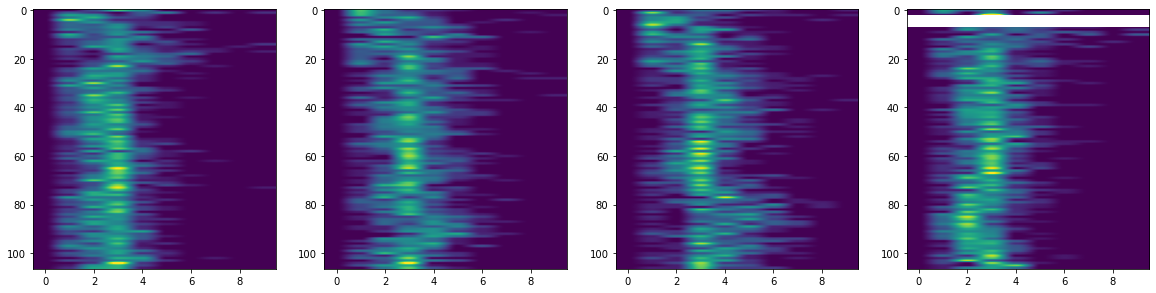

In [411]:
fig,axes=plt.subplots(1,4,figsize=(20, 10))
for a in [0,1,2,3]: #arms
    axes[a].imshow(histograms[:,:,a],aspect=0.1,vmax=0.7)
    
    # seq ticks
    sequence_change=np.argwhere(np.diff(seqtype_int)).ravel()+1
    xlim=axes[a].get_xlim()
    for t in sequence_change:
        axes[a].plot(xlim,[t-0.5,t-0.5],'w:',linewidth=1,)

In [401]:
from scipy.stats import entropy
E1 = np.zeros((len(data['trials']),4))
for s in range(len(data['trials'])):
    for a in [0,1,2,3]: #arms
        E1[s,a]=entropy(histograms[s,:,a])
        
E2 = np.zeros((len(data['trials']),1))
for s in range(len(data['trials'])):
    mergedHist = np.hstack((histograms[s,:,0],histograms[s,:,1],histograms[s,:,2],histograms[s,:,3]))
    mergedHist = mergedHist/np.sum(mergedHist)
    E2[s] = entropy(mergedHist)

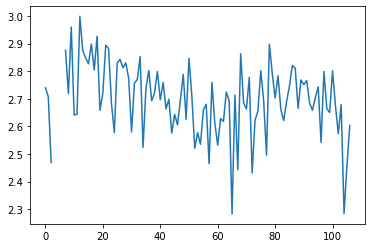

In [402]:
plt.plot(E2)

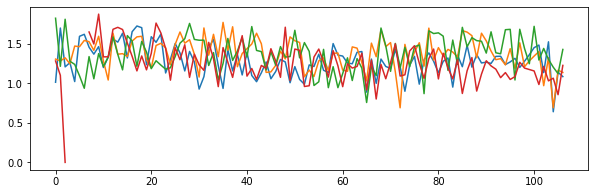

In [412]:
fig,axes=plt.subplots(1,1,figsize=(10, 3))
for a in [0,1,2,3]: #arms
    axes.plot(E1[:,a])


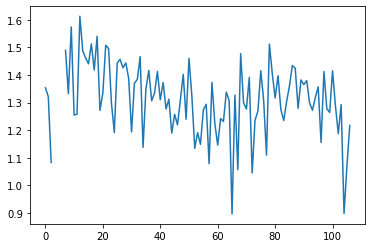

In [413]:
plt.plot(E1.mean(axis=1))

### 3. Transitions among sequences

In [577]:
def triggered_sequences(data,seq_inds,order_all,w=10):
    '''
    seq_inds, list of length=num of sessions, each element is the trial ind of the occurance of the sequence
    order_all, occurance of sequences for each trial, produced by the first part of the notebook.
    w, window length
    '''
    seq_triggered_sessions=[]

    for s in range(len(seq_inds)):
        seq_triggered=[]
        seq_ind=seq_inds[s]
        for r_ind in range(len(seq_ind)):
            op=seq_ind[r_ind]-w
            ed=seq_ind[r_ind]+w+1
            if op<0 or ed>=np.min([len(data['trials'][s][:,3]),120]):
                continue
            seq_triggered.append(order_all[s,np.arange(op,ed),:])
        seq_triggered=np.array(seq_triggered)
    
        if np.shape(seq_triggered)[0]>0:
            seq_triggered_session=np.mean(seq_triggered,axis=0)
            seq_triggered_sessions.append(seq_triggered_session)
    seq_triggered_sessions=np.array(seq_triggered_sessions)
    
    return seq_triggered_sessions

#### Start of Reverse sequence triggered rate of occurance of other sequence types

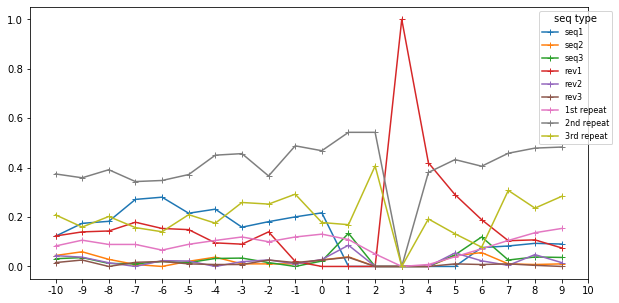

In [485]:
revop_ind=[np.argwhere(np.diff(order_all[s,:,3])==1).ravel()-2 for s in range(len(data['trials']))]
rev_triggered_sessions=triggered_sequences(data,revop_ind,order_all)

fig,axe=plt.subplots(1,1,figsize=(10, 5))#,sharey=True,sharex=True)

for seq_ind in range(9):
    #if seq_ind==3:
    #    continue
    axe.plot(np.mean(rev_triggered_sessions[:,:,seq_ind],axis=0),'+-',color='C'+str(seq_ind),label=orders[seq_ind])

axe.set_xticks(np.arange(2*w+1))
axe.set_xticklabels([str(tick) for tick in (np.arange(2*w+1)-w)])
axe.legend(fontsize=8,bbox_to_anchor=(1.05, 1),ncol=1,title='seq type')

#### Start of forward sequence triggered other sequence occurance

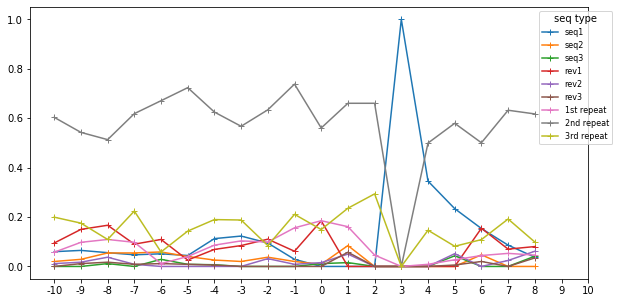

In [467]:
seq1op_ind=[np.argwhere(np.diff(order_all[s,:,0])==1).ravel()-2 for s in range(len(data['trials']))]
seq1op_triggered_sessions=triggered_sequences(data,seq1op_ind,order_all)

fig,axe=plt.subplots(1,1,figsize=(10, 5))#,sharey=True,sharex=True)

for seq_ind in range(9):
    #if seq_ind==3:
    #    continue
    axe.plot(np.mean(seq1op_triggered_sessions[:,:,seq_ind],axis=0),'+-',color='C'+str(seq_ind),label=orders[seq_ind])

axe.set_xticks(np.arange(2*w+1))
axe.set_xticklabels([str(tick) for tick in (np.arange(2*w+1)-w)])
axe.legend(fontsize=8,bbox_to_anchor=(1.05, 1),ncol=1,title='seq type')

#### End of forward sequence triggered other sequence occurance

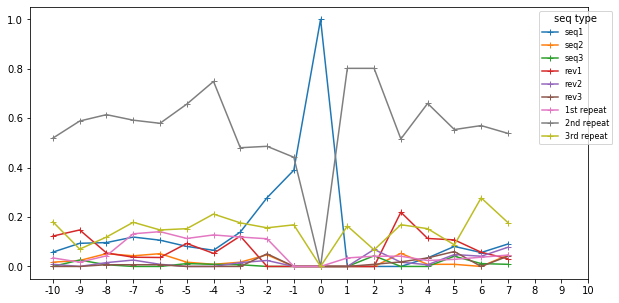

In [461]:
seq1ed_ind=[np.argwhere(np.diff(order_all[s,:,0])==-1).ravel() for s in range(len(data['trials']))]
seq1ed_triggered_sessions=triggered_sequences(data,seq1ed_ind,order_all)

fig,axe=plt.subplots(1,1,figsize=(10, 5))#,sharey=True,sharex=True)

for seq_ind in range(9):
    #if seq_ind==3:
    #    continue
    axe.plot(np.mean(seq1ed_triggered_sessions[:,:,seq_ind],axis=0),'+-',color='C'+str(seq_ind),label=orders[seq_ind])

axe.set_xticks(np.arange(2*w+1))
axe.set_xticklabels([str(tick) for tick in (np.arange(2*w+1)-w)])
axe.legend(fontsize=8,bbox_to_anchor=(1.05, 1),ncol=1,title='seq type')

####
The asymmetric shape of the blue curve means that seq1 comes often not in quadrupples but also in 5's or 6's

#### cross correlation between end of forward sequence and beginning of reverse sequence

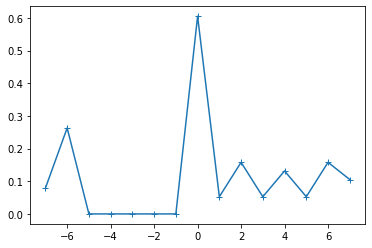

In [469]:
xcorr_sessions=[]
for s in range(len(data['trials'])):
    seq1_ind_ed=np.diff(order_all[s,:,0])==-1
    seq2_ind_tmp=np.argwhere(np.diff(order_all[s,:,3])==1).ravel()-2
    seq2_ind_op=np.zeros_like(seq1_ind_ed)
    seq2_ind_op[seq2_ind_tmp]=1

    timeseries1=seq1_ind_ed[~np.isnan(seq1_ind_ed)].astype('int')
    timeseries2=seq2_ind_op[~np.isnan(seq1_ind_ed)].astype('int')
    xcorr=np.correlate(timeseries1,timeseries2,"full")
    xcorr_sessions.append(xcorr)

xcorr_sessions=np.array(xcorr_sessions)
x_axis=np.arange(len(xcorr))-((len(xcorr)+1)/2-1)
middle_op=int((len(xcorr)+1)/2-1-7)
middle_ed=int((len(xcorr)+1)/2-1+8)
x_plot=x_axis[np.arange(middle_op,middle_ed)]
xcorr_plot=np.mean(xcorr_sessions[:,np.arange(middle_op,middle_ed)],axis=0)
plt.plot(x_plot,xcorr_plot[::-1],'+-')

#### cross correlation between the beginning of forward sequence and reverse sequence

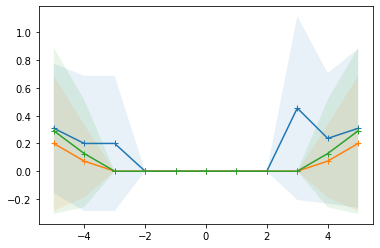

In [585]:
xcorr_sessions=[]
acorr_sessions_forward=[]
acorr_sessions_reverse=[]

for s in range(len(data['trials'])):
    seq1_ind_tmp=np.argwhere(np.diff(order_all[s,:,0])==1).ravel()-2
    seq1_ind_op=np.zeros_like(np.diff(order_all[s,:,0]))
    seq1_ind_op[seq1_ind_tmp]=1
    
    seq2_ind_tmp=np.argwhere(np.diff(order_all[s,:,3])==1).ravel()-2
    seq2_ind_op=np.zeros_like(seq1_ind_op)
    seq2_ind_op[seq2_ind_tmp]=1

    timeseries1=seq1_ind_op[~np.isnan(seq1_ind_op)].astype('int')
    timeseries2=seq2_ind_op[~np.isnan(seq1_ind_op)].astype('int')
    xcorr=np.correlate(timeseries1,timeseries2,"full")
    xcorr_sessions.append(xcorr)
    
    acorr=np.correlate(timeseries1,timeseries1,"full")
    acorr_sessions_forward.append(acorr)
    
    acorr=np.correlate(timeseries2,timeseries2,"full")
    acorr_sessions_reverse.append(acorr)

xcorr_sessions=np.array(xcorr_sessions)
acorr_sessions_forward=np.array(acorr_sessions_forward)
acorr_sessions_reverse=np.array(acorr_sessions_reverse)

x_axis=np.arange(len(xcorr))-((len(xcorr)+1)/2-1)
middle_op=int((len(xcorr)+1)/2-1-5)
middle_ed=int((len(xcorr)+1)/2-1+6)
x_plot=x_axis[np.arange(middle_op,middle_ed)]
xcorr_plot=np.mean(xcorr_sessions[:,np.arange(middle_op,middle_ed)],axis=0)
xcorr_std=np.std(xcorr_sessions[:,np.arange(middle_op,middle_ed)],axis=0,ddof=1)

plt.fill_between(x_plot,xcorr_plot[::-1]-xcorr_std[::-1],xcorr_plot[::-1]+xcorr_std[::-1],facecolor='C0',alpha=0.1)
plt.plot(x_plot,xcorr_plot[::-1],'+-')


acorr_forward_plot=np.mean(acorr_sessions_forward[:,np.arange(middle_op,middle_ed)],axis=0)
acorr_forward_plot[int((len(acorr_forward_plot)+1)/2-1)]=0
acorr_std=np.std(acorr_sessions_forward[:,np.arange(middle_op,middle_ed)],axis=0,ddof=1)
acorr_std[int((len(acorr_std)+1)/2-1)]=0

plt.fill_between(x_plot,acorr_forward_plot[::-1]-acorr_std[::-1],acorr_forward_plot[::-1]+acorr_std[::-1],facecolor='C1',alpha=0.1)
plt.plot(x_plot,acorr_forward_plot[::-1],'+-')

acorr_reverse_plot=np.mean(acorr_sessions_reverse[:,np.arange(middle_op,middle_ed)],axis=0)
acorr_reverse_plot[int((len(acorr_reverse_plot)+1)/2-1)]=0
acorr_std=np.std(acorr_sessions_reverse[:,np.arange(middle_op,middle_ed)],axis=0,ddof=1)
acorr_std[int((len(acorr_std)+1)/2-1)]=0

plt.fill_between(x_plot,acorr_reverse_plot[::-1]-acorr_std[::-1],acorr_reverse_plot[::-1]+acorr_std[::-1],facecolor='C2',alpha=0.1)
plt.plot(x_plot,acorr_reverse_plot[::-1],'+-')

fig.text(0.5, 0.001,'lag (trial), to the right = move seq1 to the right', ha='center',fontsize=20);
axe.legend(fontsize=8,bbox_to_anchor=(1.05, 1),ncol=1,title='seq type')